# Тестирование

In [1]:
from __future__ import print_function
from tqdm.notebook import tqdm
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import pytorch_warmup as warmup

import torch.utils

from utils import*

import os
import numpy as np
import torch
import torch.utils.data
import pandas as pd
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from utils_fucntions import*

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

IMAGE_SIZE = 256

In [2]:
num_classes = 46 + 1

## Датасет

In [3]:
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, height, width, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.height = height
        self.width = width

    def __getitem__(self, idx):
        img_path = os.listdir(self.image_dir)[idx]
        img = Image.open(self.image_dir + img_path).convert("RGB")
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, img_path.split('/')[-1]

    def __len__(self):
        return len(os.listdir(self.image_dir))

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
dataset_test = InferenceDataset("D:/project/test/",
                               IMAGE_SIZE,
                               IMAGE_SIZE,
                               transforms=transform)

test_data_loader  = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

## Модель

In [6]:
def get_MaskRCNN_Model(num_classes, device):
    model_ft =torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
    model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model_ft.to(device)
    for param in model_ft.parameters():
        param.requires_grad = True
        
    return model_ft

model_ft = get_MaskRCNN_Model(num_classes, device)
model_ft.load_state_dict(torch.load('half3_adam_warmup_pytorch_mrcnn_256'))
model_ft.eval();

In [7]:
!nvidia-smi

Tue May 18 20:01:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0    25W /  N/A |   1067MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Predict

In [8]:
def create_final_df(result_dict):
    final_df = {'ImageId': [], 'EncodedPixels': [], 'ClassId': []}
    for im_name, im_dict in result_dict.items():
        final_df['ImageId'] += [im_name] * len(im_dict)
        for cls_id, enc_p in im_dict.items():
            final_df['EncodedPixels'].append(enc_p)
            final_df['ClassId'].append(cls_id)

    return pd.DataFrame(final_df)

class InfernceModel(object):
    def __init__(self,
                 nn_model,
                 device,
                 output_size=(IMAGE_SIZE, IMAGE_SIZE),
                 threshold=0.5,
                 size_min_mask=250):
        self.nn_model = nn_model
        
        self.output_size = output_size
        self.threshold = threshold
        self.size_min_mask = size_min_mask
        self.device = device

    def __call__(self, dataloader):
        self.nn_model.eval()
        result = {}
        with torch.no_grad():
            for batch in tqdm(dataloader):
                name = batch[1]
#                 print(name)
                batch = self.nn_model([batch[0].to(self.device)])[0]
                result[name] = self.post_process(batch['masks'].cpu().numpy(),
                                                 batch['labels'].cpu().numpy(),
                                                 batch['scores'].cpu().numpy())

        final_df = create_final_df(result)
        final_df['Height'] = self.output_size[0]
        final_df['Width'] = self.output_size[1]
        final_df['ClassId'] = final_df['ClassId'].astype(str)

        return final_df

    def post_process(self, masks, labels, scores):
        labels -= 1

        rle_mask = {}
        if scores.max() < 0.05:
            cur_idx = scores.argmax()

            item_mask = (masks[cur_idx][0] > self.threshold).astype(np.uint8)
            item_mask = cv2.resize(item_mask, self.output_size)

            if item_mask.sum() >= self.size_min_mask:
                rle_mask[str(labels[cur_idx])] = rle_encode(item_mask)

        else:

            good_masks = masks[scores > 0.05]
            good_labels = labels[scores > 0.05]

            for m, l in zip(masks, labels):

                item_mask = (m[0] > self.threshold).astype(np.uint8)
                item_mask = cv2.resize(item_mask, self.output_size)

                if item_mask.sum() < self.size_min_mask:
                    continue
                else:
                    rle_mask[str(l)] = rle_encode(item_mask)

        return rle_mask

In [9]:
inf_model = InfernceModel(model_ft, device=device)
dataset = [dataset_test.__getitem__(i) for i in tqdm(range(len(dataset_test)))]

  0%|          | 0/3198 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
try:
    predicted_df = pd.read_csv('predicted_df.csv')
except:
    predicted_df = inf_model(dataset)
    predicted_df.to_csv('predicted_df.csv', index = False)

C:\Users\Kirill_Sergeev\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


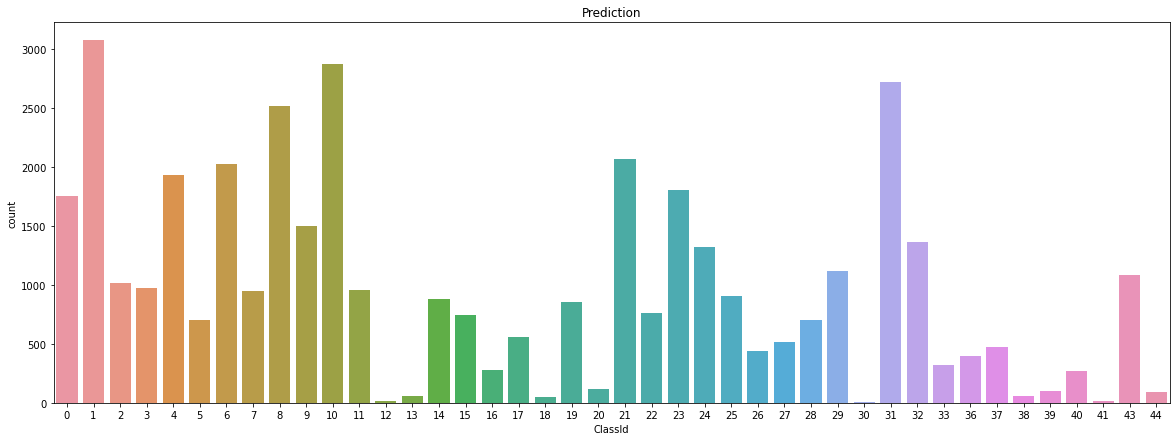

In [11]:
plt.figure(figsize=(20, 7))
plt.title('Prediction')
sns.countplot(predicted_df['ClassId']);

In [12]:
def make_mask(IMG_FILE, train_df):
    df = train_df[train_df.ImageId == IMG_FILE].reset_index(drop = True)
    H = 256
    W = 256
    
    mask = np.full(H*W,dtype='int',fill_value = -1)
    
    for line in df[['EncodedPixels','ClassId']].iterrows():
        EncodedPixels = line[1][0]
        ClassId = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = ClassId
    
    mask = mask.reshape(W,H).T
    
    return mask


def Masking_Image(train_df):
    
    ind = list(np.random.randint(0,  len(train_df['ImageId'].unique()), 10))
    num_subplots = len(train_df['ImageId'].unique()[ind])
    fig, ax = plt.subplots(nrows=num_subplots, ncols=3, figsize=(18, num_subplots*6))
    i = 0
    for image_name in train_df['ImageId'].unique()[ind]:
        I = cv2.imread("D:/project/test/" + image_name, cv2.IMREAD_COLOR)
        I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
        I = cv2.resize(I, (IMAGE_SIZE, IMAGE_SIZE))
        mask = make_mask(image_name, train_df)

        

        ax[i][0].imshow(I)
        ax[i][1].imshow(mask, cmap='jet')

        ax[i][2].imshow(I, interpolation='none')
        ax[i][2].imshow(mask, cmap='jet', interpolation='none', alpha=0.7)
        i+=1

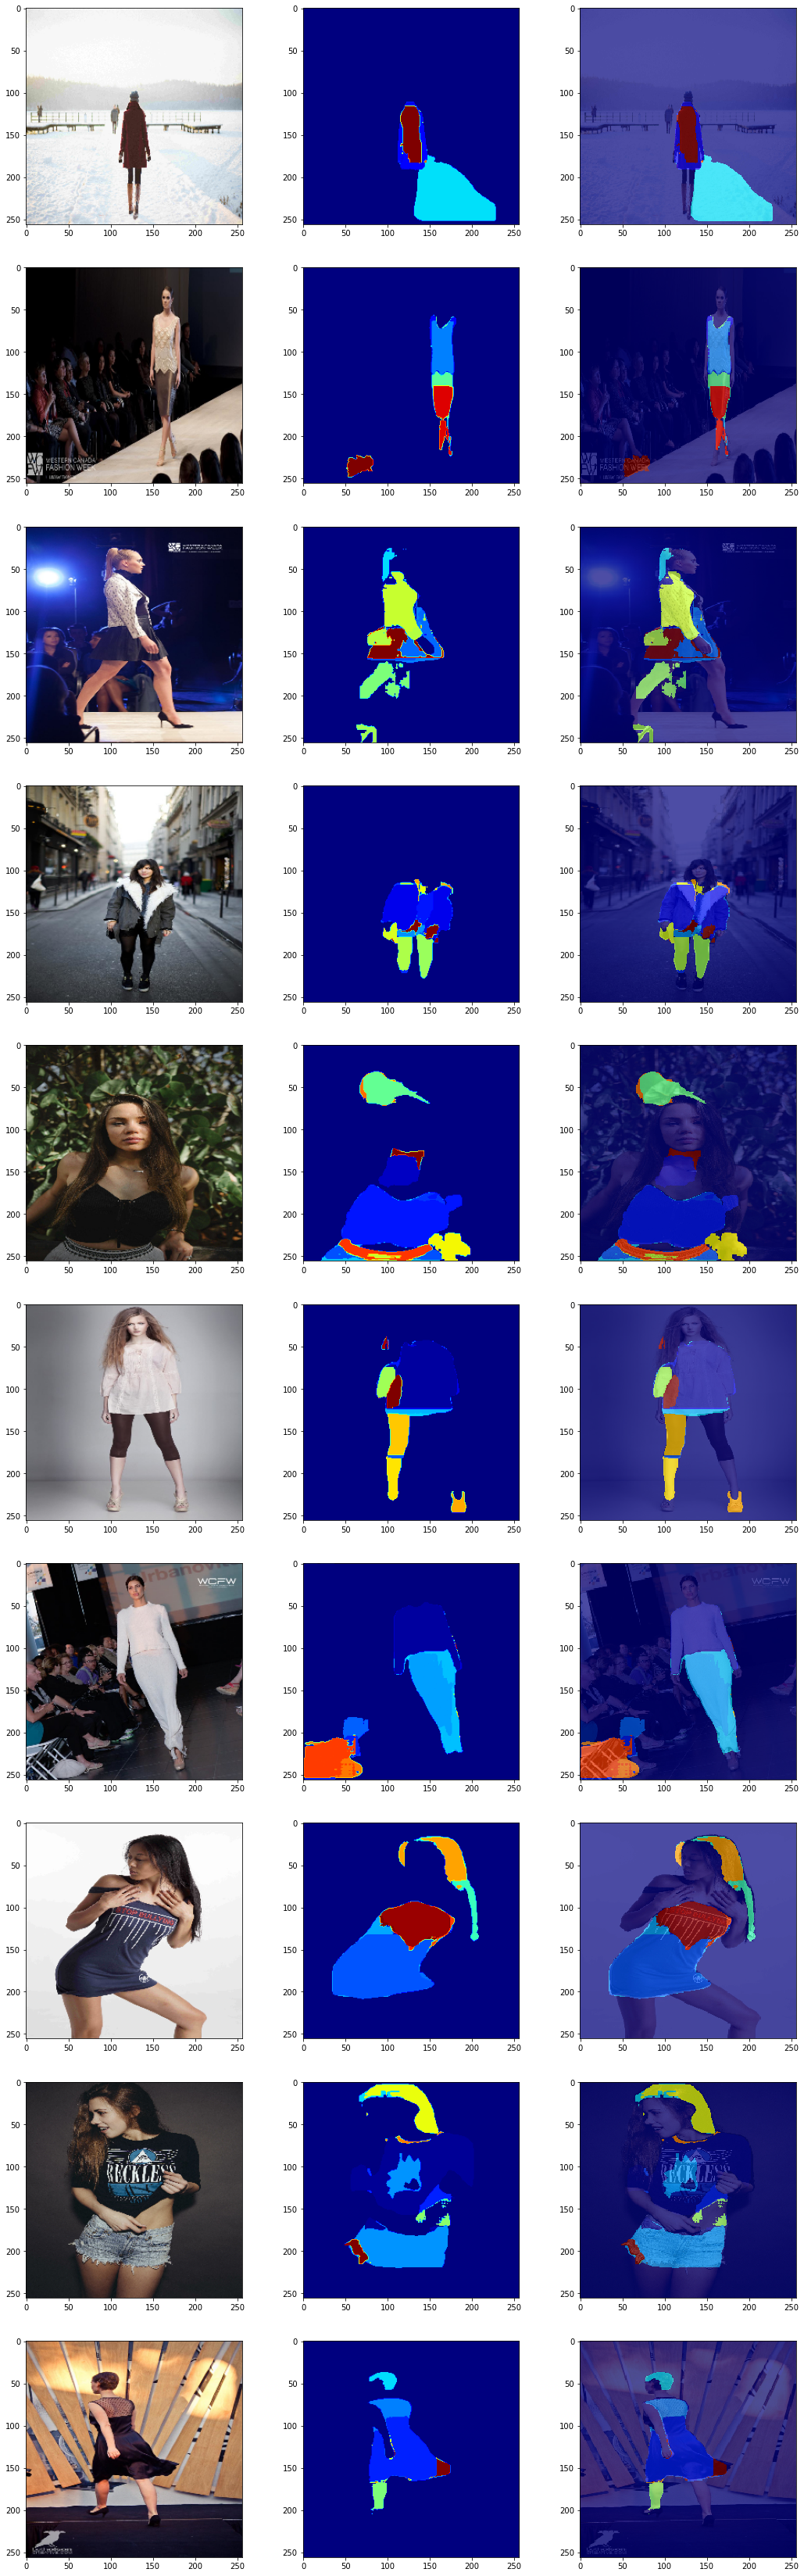

In [13]:
Masking_Image(predicted_df)